In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd '/content/drive/My Drive/Fall 2020/1006 Capstone/NYU_Team18_Accern_Capstone_Fall2020/'

/content/drive/My Drive/Fall 2020/1006 Capstone/NYU_Team18_Accern_Capstone_Fall2020


In [ ]:
!pip install transformers
!pip install pytorch-lightning==1.0.8

     |████████████████████████████████| 1.4MB 21.9MB/s 
     |████████████████████████████████| 2.9MB 53.5MB/s 
     |████████████████████████████████| 890kB 46.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=8ae71bf31964df55d5cbec4c298f03ab59e2c8e005e5635964cfdd28a020af8d
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 563kB 17.1MB/s 
     |████████████████████████████████| 276kB 54.0MB/s 
     |████████████████████████████████| 92kB 13.5MB/s 
     |████████████████████████████████| 829kB 58.3MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44620 sha256=c50e1d33daa30d4658368da541beb8ed325bb0a57d9fa5ab4a520570d84a2915
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
  Created wheel for future: filename=future

In [ ]:
import numpy as np
import pandas as pd
import torch

from read_data import *
from FinSentiment import *

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


# Train Models

### Train on Correct

In [ ]:
pretrained_bert_name = 'distilbert-base-cased'
incorrect_type = 'correct'
company_embedding_method = 'concat'
company_weight = 2
burn_in_epochs = 2
max_epochs = burn_in_epochs + 4
existing_company_only = False

model_name = '_'.join([pretrained_bert_name, incorrect_type, company_embedding_method]) + '_full_data'

#############################################################################################
tokenizer = DistilBertTokenizer.from_pretrained(pretrained_bert_name)
(train_ids,X_train,y_train), (val_ids,X_val,y_val), (test_ids,X_test,y_test), _ = read_data(incorrect_type, dir_path='data/', existing_company_only=existing_company_only, sample=None)

X_train = np.concatenate([X_train, X_val])
y_train = np.concatenate([y_train, y_val])
train_ids = np.concatenate([train_ids, val_ids])

train_dataloader = tokenize_and_dataloader(X_train, y_train, tokenizer, train_ids, 16, 4, random=True)
val_dataloader = tokenize_and_dataloader(X_test, y_test, tokenizer, test_ids, 16, 4, random=False)

#############################################################################################
model = FinSentiment(pretrained_bert_name, incorrect_type, company_embedding_method, company_weight, 
                     lr=5e-5, hidden_dropout_prob=0.1, discriminate=True, burn_in_epochs=burn_in_epochs)

logger = TensorBoardLogger('experiments/logs', name=model_name)
checkpoint_callback = ModelCheckpoint(
    filepath = 'experiments/saved_models/' + company_embedding_method + '/' + model_name + '/' + model_name,
    monitor='val_loss',
    mode='min',
    save_top_k=1,
    save_last=True,
    verbose=False
)
trainer = pl.Trainer(progress_bar_refresh_rate=20, gpus=1, max_epochs=max_epochs, logger=logger, callbacks=[checkpoint_callback], fast_dev_run=False)
trainer.fit(model, train_dataloader, val_dataloader)

trainer.save_checkpoint('experiments/saved_models/' + company_embedding_method + '/' + model_name + '/' + model_name + '_last.ckpt')

[PROGRESS] Saving hyperparameters
[PROGRESS] Initializing BERT model



[PROGRESS] Initializing Company Embedding Layer
[PROGRESS] Initializing classifier
[PROGRESS] Done initialization


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type            | Params
--------------------------------------------------
0 | bert          | DistilBertModel | 65.2 M
1 | company_layer | Embedding       | 808 K 
2 | classifier    | Sequential      | 2.4 M 
3 | pooler        | BertPooler      | 590 K 
4 | dropout       | Dropout         | 0     


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (3) and target (4) number of classes
  warnings.warn(*args, **kwargs)


[PROGRESS] Burning in classifier epoch 0


[PROGRESS] Burning in classifier epoch 1


Saving latest checkpoint...


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (14) and target (5) number of classes
  warnings.warn(*args, **kwargs)


[MODEL NAME]: distilbert-base-cased_correct_concat 	 [INCORRECT TYPE]: correct
RESULTS:
	Accuracy: 		0.9517
	Weighted Accuracy: 	0.9569
	F1 Score: 		0.9517
	AUC_SCORE[CLS 0]: 	0.9984
	AUC_SCORE[CLS 1]: 	0.9929
	AUC_SCORE[CLS 2]: 	0.9603
	AUC_SCORE[CLS 3]: 	0.9829
	AUC_SCORE[CLS 4]: 	0.9985

Confusion Matrix


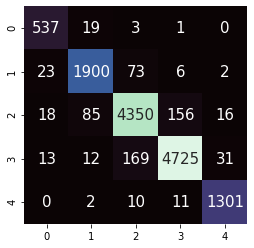

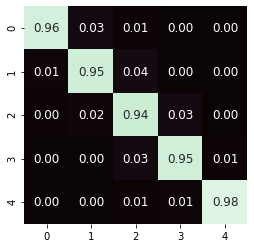

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_correct_concat 	 [INCORRECT TYPE]: inverse
RESULTS:
	Accuracy: 		0.8493
	Weighted Accuracy: 	0.8054
	F1 Score: 		0.8493
	AUC_SCORE[CLS 0]: 	0.8365
	AUC_SCORE[CLS 1]: 	0.8060
	AUC_SCORE[CLS 2]: 	0.9573
	AUC_SCORE[CLS 3]: 	0.8977
	AUC_SCORE[CLS 4]: 	0.9234

Confusion Matrix


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (14) and target (5) number of classes
  warnings.warn(*args, **kwargs)


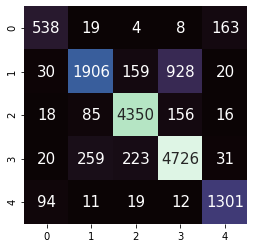

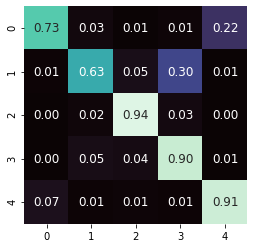

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_correct_concat 	 [INCORRECT TYPE]: boundary
	Boundary Accuracy: 		0.8522
	Drop Total Sample: 		884.0000
--------------------------------------------------------------------------------



In [ ]:
evaluate_model(model, tokenizer, trainer, existing_company_only=False, dir_path='data/',batch_size=16, num_workers=4)

[MODEL NAME]: distilbert-base-cased_correct_concat 	 [INCORRECT TYPE]: correct
RESULTS:
	Accuracy: 		0.9503
	Weighted Accuracy: 	0.9552
	F1 Score: 		0.9503
	AUC_SCORE[CLS 0]: 	0.9975
	AUC_SCORE[CLS 1]: 	0.9929
	AUC_SCORE[CLS 2]: 	0.9559
	AUC_SCORE[CLS 3]: 	0.9829
	AUC_SCORE[CLS 4]: 	0.9990

Confusion Matrix


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (14) and target (5) number of classes
  warnings.warn(*args, **kwargs)


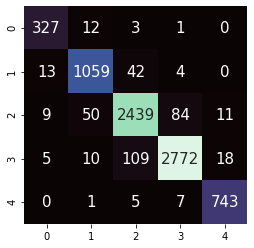

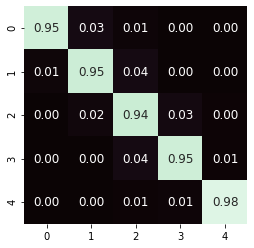

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_correct_concat 	 [INCORRECT TYPE]: inverse
RESULTS:
	Accuracy: 		0.8407
	Weighted Accuracy: 	0.7934
	F1 Score: 		0.8407
	AUC_SCORE[CLS 0]: 	0.8413
	AUC_SCORE[CLS 1]: 	0.7897
	AUC_SCORE[CLS 2]: 	0.9535
	AUC_SCORE[CLS 3]: 	0.8945
	AUC_SCORE[CLS 4]: 	0.9172

Confusion Matrix


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (14) and target (5) number of classes
  warnings.warn(*args, **kwargs)


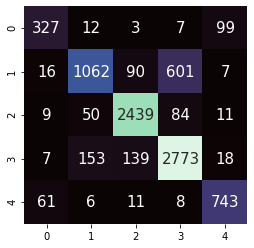

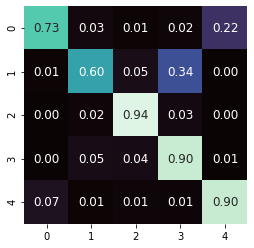

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_correct_concat 	 [INCORRECT TYPE]: boundary
	Boundary Accuracy: 		0.8405
	Drop Total Sample: 		519.0000
--------------------------------------------------------------------------------



In [ ]:
evaluate_model(model, tokenizer, trainer, existing_company_only=True, dir_path='data/',batch_size=16, num_workers=4)

### Train on Inverse

In [ ]:
pretrained_bert_name = 'distilbert-base-cased'
incorrect_type = 'inverse'
company_embedding_method = 'concat'
company_weight = 2
burn_in_epochs = 2
max_epochs = burn_in_epochs + 4
existing_company_only = False

model_name = '_'.join([pretrained_bert_name, incorrect_type, company_embedding_method]) + '_full_data'

#############################################################################################
tokenizer = DistilBertTokenizer.from_pretrained(pretrained_bert_name)
(train_ids,X_train,y_train), (val_ids,X_val,y_val), (test_ids,X_test,y_test), _ = read_data(incorrect_type, dir_path='data/', existing_company_only=existing_company_only, sample=None)

X_train = np.concatenate([X_train, X_val])
y_train = np.concatenate([y_train, y_val])
train_ids = np.concatenate([train_ids, val_ids])

train_dataloader = tokenize_and_dataloader(X_train, y_train, tokenizer, train_ids, 16, 4, random=True)
val_dataloader = tokenize_and_dataloader(X_test, y_test, tokenizer, test_ids, 16, 4, random=False)

#############################################################################################
model = FinSentiment(pretrained_bert_name, incorrect_type, company_embedding_method, company_weight, 
                     lr=5e-5, hidden_dropout_prob=0.1, discriminate=True, burn_in_epochs=burn_in_epochs)

logger = TensorBoardLogger('experiments/logs', name=model_name)
checkpoint_callback = ModelCheckpoint(
    filepath = 'experiments/saved_models/' + company_embedding_method + '/' + model_name + '/' + model_name,
    monitor='val_loss',
    mode='min',
    save_top_k=1,
    save_last=True,
    verbose=False
)
trainer = pl.Trainer(progress_bar_refresh_rate=20, gpus=1, max_epochs=max_epochs, logger=logger, callbacks=[checkpoint_callback], fast_dev_run=False)
trainer.fit(model, train_dataloader, val_dataloader)

trainer.save_checkpoint('experiments/saved_models/' + company_embedding_method + '/' + model_name + '/' + model_name + '_last.ckpt')

[PROGRESS] Saving hyperparameters
[PROGRESS] Initializing BERT model


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[PROGRESS] Initializing Company Embedding Layer
[PROGRESS] Initializing classifier
[PROGRESS] Done initialization



  | Name          | Type            | Params
--------------------------------------------------
0 | bert          | DistilBertModel | 65.2 M
1 | company_layer | Embedding       | 808 K 
2 | classifier    | Sequential      | 2.4 M 
3 | pooler        | BertPooler      | 590 K 
4 | dropout       | Dropout         | 0     


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (4) and target (4) number of classes
  warnings.warn(*args, **kwargs)


[PROGRESS] Burning in classifier epoch 0


[PROGRESS] Burning in classifier epoch 1


Saving latest checkpoint...


In [ ]:
evaluate_model(model, tokenizer, trainer, existing_company_only=False, dir_path='data/',batch_size=16, num_workers=4)

[MODEL NAME]: distilbert-base-cased_inverse_concat 	 [INCORRECT TYPE]: correct
RESULTS:
	Accuracy: 		0.9291
	Weighted Accuracy: 	0.9480
	F1 Score: 		0.9291
	AUC_SCORE[CLS 0]: 	0.9963
	AUC_SCORE[CLS 1]: 	0.9701
	AUC_SCORE[CLS 2]: 	0.9660
	AUC_SCORE[CLS 3]: 	0.9773
	AUC_SCORE[CLS 4]: 	0.9985

Confusion Matrix


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (10) and target (5) number of classes
  warnings.warn(*args, **kwargs)


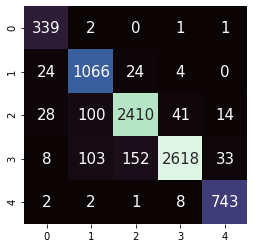

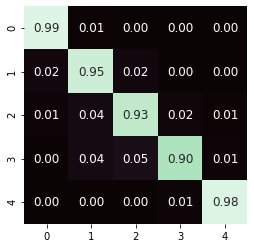

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_inverse_concat 	 [INCORRECT TYPE]: inverse
RESULTS:
	Accuracy: 		0.9024
	Weighted Accuracy: 	0.9102
	F1 Score: 		0.9024
	AUC_SCORE[CLS 0]: 	0.9932
	AUC_SCORE[CLS 1]: 	0.9602
	AUC_SCORE[CLS 2]: 	0.9702
	AUC_SCORE[CLS 3]: 	0.9639
	AUC_SCORE[CLS 4]: 	0.9966

Confusion Matrix


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (10) and target (5) number of classes
  warnings.warn(*args, **kwargs)


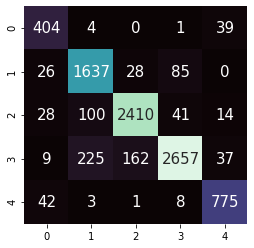

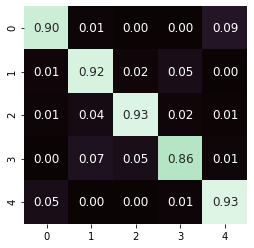

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_inverse_concat 	 [INCORRECT TYPE]: boundary
	Boundary Accuracy: 		0.9093
	Drop Total Sample: 		581.0000
--------------------------------------------------------------------------------



In [ ]:
evaluate_model(model, tokenizer, trainer, existing_company_only=True, dir_path='data/',batch_size=16, num_workers=4)

### Train on Boundary

In [ ]:
pretrained_bert_name = 'distilbert-base-cased'
incorrect_type = 'boundary'
company_embedding_method = 'concat'
company_weight = 2
burn_in_epochs = 2
max_epochs = burn_in_epochs + 4
existing_company_only = False

model_name = '_'.join([pretrained_bert_name, incorrect_type, company_embedding_method]) + '_full_data'

#############################################################################################
tokenizer = DistilBertTokenizer.from_pretrained(pretrained_bert_name)
(train_ids,X_train,y_train), (val_ids,X_val,y_val), (test_ids,X_test,y_test), _ = read_data(incorrect_type, dir_path='data/', existing_company_only=existing_company_only, sample=None)

X_train = np.concatenate([X_train, X_val])
y_train = np.concatenate([y_train, y_val])
train_ids = np.concatenate([train_ids, val_ids])

train_dataloader = tokenize_and_dataloader(X_train, y_train, tokenizer, train_ids, 16, 4, random=True)
val_dataloader = tokenize_and_dataloader(X_test, y_test, tokenizer, test_ids, 16, 4, random=False)

#############################################################################################
model = FinSentiment(pretrained_bert_name, incorrect_type, company_embedding_method, company_weight, 
                     lr=5e-5, hidden_dropout_prob=0.1, discriminate=True, burn_in_epochs=burn_in_epochs)

logger = TensorBoardLogger('experiments/logs', name=model_name)
checkpoint_callback = ModelCheckpoint(
    filepath = 'experiments/saved_models/' + company_embedding_method + '/' + model_name + '/' + model_name,
    monitor='val_loss',
    mode='min',
    save_top_k=1,
    save_last=True,
    verbose=False
)
trainer = pl.Trainer(progress_bar_refresh_rate=20, gpus=1, max_epochs=max_epochs, logger=logger, callbacks=[checkpoint_callback], fast_dev_run=False)
trainer.fit(model, train_dataloader, val_dataloader)

trainer.save_checkpoint('experiments/saved_models/' + company_embedding_method + '/' + model_name + '/' + model_name + '_last.ckpt')

In [ ]:
evaluate_model(model, tokenizer, trainer, existing_company_only=False, dir_path='data/',batch_size=16, num_workers=4)

[MODEL NAME]: distilbert-base-cased_boundary_concat 	 [INCORRECT TYPE]: correct
RESULTS:
	Accuracy: 		0.9417
	Weighted Accuracy: 	0.9424
	F1 Score: 		0.9417
	AUC_SCORE[CLS 0]: 	0.9947
	AUC_SCORE[CLS 1]: 	0.9897
	AUC_SCORE[CLS 2]: 	0.9811
	AUC_SCORE[CLS 3]: 	0.9877
	AUC_SCORE[CLS 4]: 	0.9965

Confusion Matrix


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (11) and target (5) number of classes
  warnings.warn(*args, **kwargs)


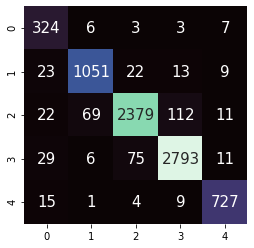

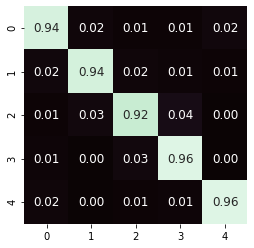

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_boundary_concat 	 [INCORRECT TYPE]: inverse
RESULTS:
	Accuracy: 		0.8618
	Weighted Accuracy: 	0.8505
	F1 Score: 		0.8618
	AUC_SCORE[CLS 0]: 	0.9616
	AUC_SCORE[CLS 1]: 	0.9772
	AUC_SCORE[CLS 2]: 	0.9827
	AUC_SCORE[CLS 3]: 	0.9775
	AUC_SCORE[CLS 4]: 	0.9839

Confusion Matrix


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (11) and target (5) number of classes
  warnings.warn(*args, **kwargs)


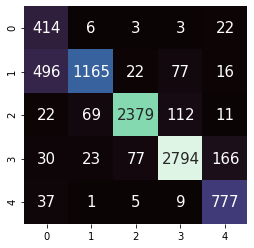

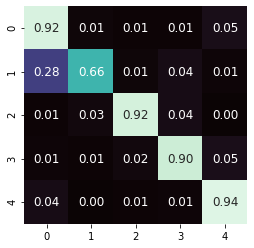

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_boundary_concat 	 [INCORRECT TYPE]: boundary
	Boundary Accuracy: 		0.9638
	Drop Total Sample: 		338.0000
--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_boundary_concat 	 [INCORRECT TYPE]: correct
RESULTS:
	Accuracy: 		0.9417
	Weighted Accuracy: 	0.9424
	F1 Score: 		0.9417
	AUC_SCORE[CLS 0]: 	0.9947
	AUC_SCORE[CLS 1]: 	0.9897
	AUC_SCORE[CLS 2]: 	0.9811
	AUC_SCORE[CLS 3]: 	0.9877
	AUC_SCORE[CLS 4]: 	0.9965

Confusion Matrix


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (11) and target (5) number of classes
  warnings.warn(*args, **kwargs)


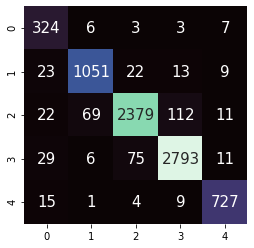

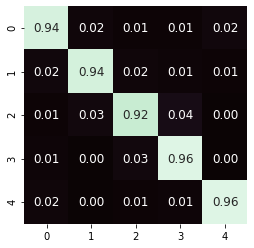

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_boundary_concat 	 [INCORRECT TYPE]: inverse
RESULTS:
	Accuracy: 		0.8618
	Weighted Accuracy: 	0.8505
	F1 Score: 		0.8618
	AUC_SCORE[CLS 0]: 	0.9616
	AUC_SCORE[CLS 1]: 	0.9772
	AUC_SCORE[CLS 2]: 	0.9827
	AUC_SCORE[CLS 3]: 	0.9775
	AUC_SCORE[CLS 4]: 	0.9839

Confusion Matrix


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (11) and target (5) number of classes
  warnings.warn(*args, **kwargs)


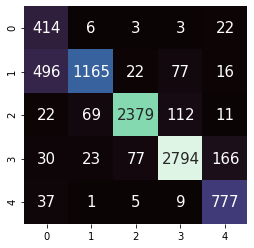

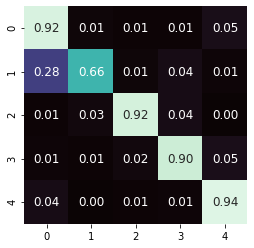

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_boundary_concat 	 [INCORRECT TYPE]: boundary
	Boundary Accuracy: 		0.9638
	Drop Total Sample: 		338.0000
--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_boundary_concat 	 [INCORRECT TYPE]: correct
RESULTS:
	Accuracy: 		0.9417
	Weighted Accuracy: 	0.9424
	F1 Score: 		0.9417
	AUC_SCORE[CLS 0]: 	0.9947
	AUC_SCORE[CLS 1]: 	0.9897
	AUC_SCORE[CLS 2]: 	0.9811
	AUC_SCORE[CLS 3]: 	0.9877
	AUC_SCORE[CLS 4]: 	0.9965

Confusion Matrix


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (11) and target (5) number of classes
  warnings.warn(*args, **kwargs)


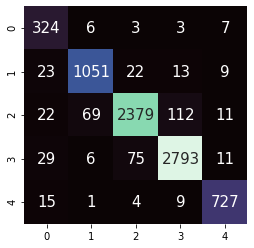

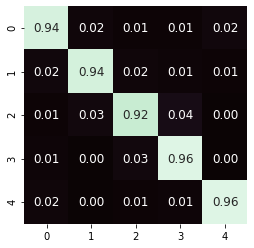

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_boundary_concat 	 [INCORRECT TYPE]: inverse
RESULTS:
	Accuracy: 		0.8618
	Weighted Accuracy: 	0.8505
	F1 Score: 		0.8618
	AUC_SCORE[CLS 0]: 	0.9616
	AUC_SCORE[CLS 1]: 	0.9772
	AUC_SCORE[CLS 2]: 	0.9827
	AUC_SCORE[CLS 3]: 	0.9775
	AUC_SCORE[CLS 4]: 	0.9839

Confusion Matrix


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (11) and target (5) number of classes
  warnings.warn(*args, **kwargs)


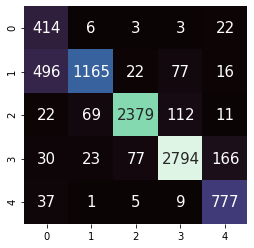

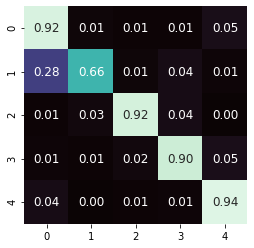

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_boundary_concat 	 [INCORRECT TYPE]: boundary
	Boundary Accuracy: 		0.9638
	Drop Total Sample: 		338.0000
--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_boundary_concat 	 [INCORRECT TYPE]: correct
RESULTS:
	Accuracy: 		0.9417
	Weighted Accuracy: 	0.9424
	F1 Score: 		0.9417
	AUC_SCORE[CLS 0]: 	0.9947
	AUC_SCORE[CLS 1]: 	0.9897
	AUC_SCORE[CLS 2]: 	0.9811
	AUC_SCORE[CLS 3]: 	0.9877
	AUC_SCORE[CLS 4]: 	0.9965

Confusion Matrix


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (11) and target (5) number of classes
  warnings.warn(*args, **kwargs)


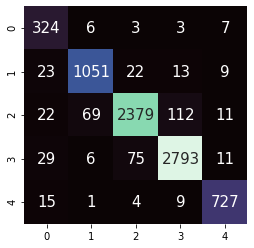

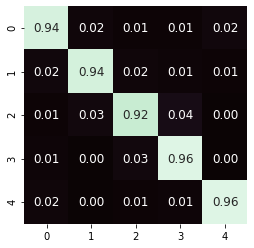

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_boundary_concat 	 [INCORRECT TYPE]: inverse
RESULTS:
	Accuracy: 		0.8618
	Weighted Accuracy: 	0.8505
	F1 Score: 		0.8618
	AUC_SCORE[CLS 0]: 	0.9616
	AUC_SCORE[CLS 1]: 	0.9772
	AUC_SCORE[CLS 2]: 	0.9827
	AUC_SCORE[CLS 3]: 	0.9775
	AUC_SCORE[CLS 4]: 	0.9839

Confusion Matrix


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (11) and target (5) number of classes
  warnings.warn(*args, **kwargs)


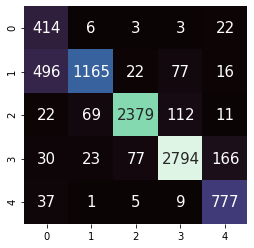

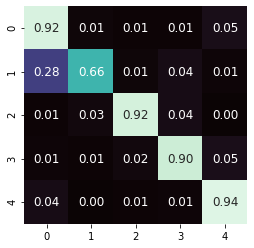

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_boundary_concat 	 [INCORRECT TYPE]: boundary
	Boundary Accuracy: 		0.9638
	Drop Total Sample: 		338.0000
--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_boundary_concat 	 [INCORRECT TYPE]: correct
RESULTS:
	Accuracy: 		0.9417
	Weighted Accuracy: 	0.9424
	F1 Score: 		0.9417
	AUC_SCORE[CLS 0]: 	0.9947
	AUC_SCORE[CLS 1]: 	0.9897
	AUC_SCORE[CLS 2]: 	0.9811
	AUC_SCORE[CLS 3]: 	0.9877
	AUC_SCORE[CLS 4]: 	0.9965

Confusion Matrix


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (11) and target (5) number of classes
  warnings.warn(*args, **kwargs)


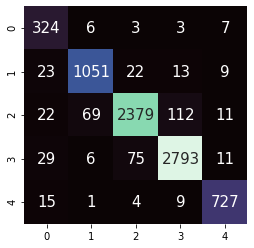

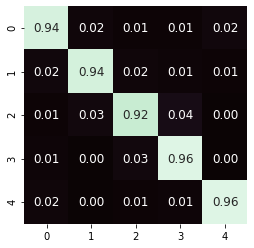

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_boundary_concat 	 [INCORRECT TYPE]: inverse
RESULTS:
	Accuracy: 		0.8618
	Weighted Accuracy: 	0.8505
	F1 Score: 		0.8618
	AUC_SCORE[CLS 0]: 	0.9616
	AUC_SCORE[CLS 1]: 	0.9772
	AUC_SCORE[CLS 2]: 	0.9827
	AUC_SCORE[CLS 3]: 	0.9775
	AUC_SCORE[CLS 4]: 	0.9839

Confusion Matrix


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (11) and target (5) number of classes
  warnings.warn(*args, **kwargs)


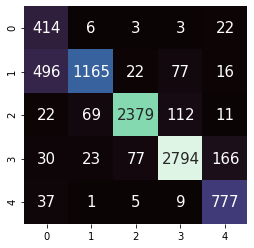

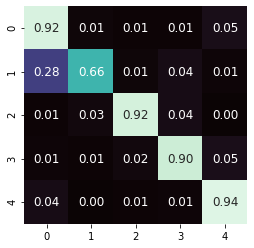

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_boundary_concat 	 [INCORRECT TYPE]: boundary
	Boundary Accuracy: 		0.9638
	Drop Total Sample: 		338.0000
--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_boundary_concat 	 [INCORRECT TYPE]: correct
RESULTS:
	Accuracy: 		0.9417
	Weighted Accuracy: 	0.9424
	F1 Score: 		0.9417
	AUC_SCORE[CLS 0]: 	0.9947
	AUC_SCORE[CLS 1]: 	0.9897
	AUC_SCORE[CLS 2]: 	0.9811
	AUC_SCORE[CLS 3]: 	0.9877
	AUC_SCORE[CLS 4]: 	0.9965

Confusion Matrix


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (11) and target (5) number of classes
  warnings.warn(*args, **kwargs)


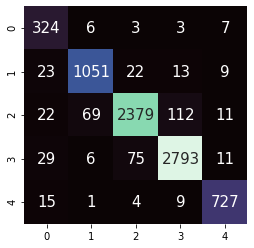

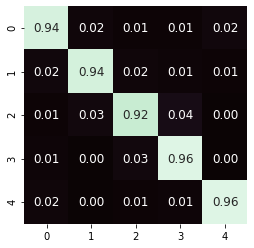

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_boundary_concat 	 [INCORRECT TYPE]: inverse
RESULTS:
	Accuracy: 		0.8618
	Weighted Accuracy: 	0.8505
	F1 Score: 		0.8618
	AUC_SCORE[CLS 0]: 	0.9616
	AUC_SCORE[CLS 1]: 	0.9772
	AUC_SCORE[CLS 2]: 	0.9827
	AUC_SCORE[CLS 3]: 	0.9775
	AUC_SCORE[CLS 4]: 	0.9839

Confusion Matrix


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (11) and target (5) number of classes
  warnings.warn(*args, **kwargs)


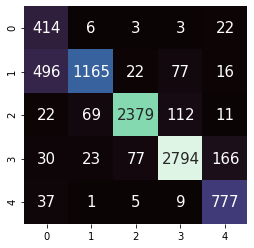

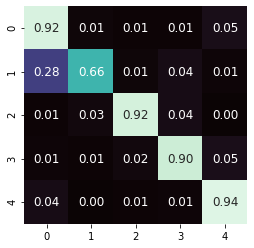

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_boundary_concat 	 [INCORRECT TYPE]: boundary
	Boundary Accuracy: 		0.9638
	Drop Total Sample: 		338.0000
--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_boundary_concat 	 [INCORRECT TYPE]: correct
RESULTS:
	Accuracy: 		0.9417
	Weighted Accuracy: 	0.9424
	F1 Score: 		0.9417
	AUC_SCORE[CLS 0]: 	0.9947
	AUC_SCORE[CLS 1]: 	0.9897
	AUC_SCORE[CLS 2]: 	0.9811
	AUC_SCORE[CLS 3]: 	0.9877
	AUC_SCORE[CLS 4]: 	0.9965

Confusion Matrix


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (11) and target (5) number of classes
  warnings.warn(*args, **kwargs)


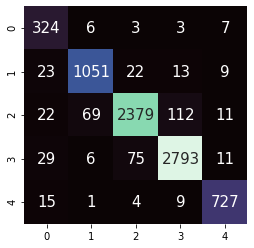

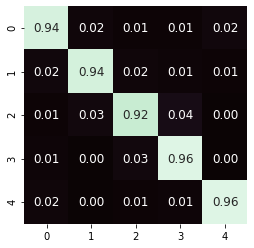

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_boundary_concat 	 [INCORRECT TYPE]: inverse
RESULTS:
	Accuracy: 		0.8618
	Weighted Accuracy: 	0.8505
	F1 Score: 		0.8618
	AUC_SCORE[CLS 0]: 	0.9616
	AUC_SCORE[CLS 1]: 	0.9772
	AUC_SCORE[CLS 2]: 	0.9827
	AUC_SCORE[CLS 3]: 	0.9775
	AUC_SCORE[CLS 4]: 	0.9839

Confusion Matrix


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (11) and target (5) number of classes
  warnings.warn(*args, **kwargs)


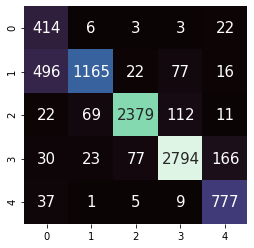

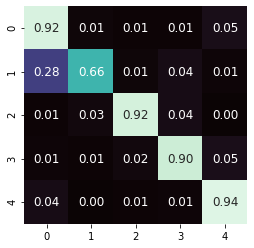

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_boundary_concat 	 [INCORRECT TYPE]: boundary
	Boundary Accuracy: 		0.9638
	Drop Total Sample: 		338.0000
--------------------------------------------------------------------------------



In [ ]:
evaluate_model(model, tokenizer, trainer, existing_company_only=True, dir_path='data/',batch_size=16, num_workers=4)

# Check Best Models

In [ ]:
pretrained_bert_name = 'distilbert-base-cased'
company_embedding_method = 'concat'

tokenizer = DistilBertTokenizer.from_pretrained(pretrained_bert_name)
trainer = pl.Trainer(progress_bar_refresh_rate=20, gpus=1)

In [ ]:
incorrect_type = 'correct'
model_name = '_'.join([pretrained_bert_name, incorrect_type, company_embedding_method])
filepath = 'experiments/saved_models/' + company_embedding_method + '/' + model_name + '/' + model_name + '-v0.ckpt'
model = FinSentiment.load_from_checkpoint(filepath)
evaluate_model(model, tokenizer, trainer, existing_company_only=True, dir_path='data/',batch_size=16, num_workers=4)

In [ ]:
incorrect_type = 'inverse'
model_name = '_'.join([pretrained_bert_name, incorrect_type, company_embedding_method])
filepath = 'experiments/saved_models/' + company_embedding_method + '/' + model_name + '/' + model_name + '-v0.ckpt'
model = FinSentiment.load_from_checkpoint(filepath)
evaluate_model(model, tokenizer, trainer, existing_company_only=True, dir_path='data/',batch_size=16, num_workers=4)

In [ ]:
incorrect_type = 'boundary'
model_name = '_'.join([pretrained_bert_name, incorrect_type, company_embedding_method])
filepath = 'experiments/saved_models/' + company_embedding_method + '/' + model_name + '/' + model_name + '-v0.ckpt'
model = FinSentiment.load_from_checkpoint(filepath)
evaluate_model(model, tokenizer, trainer, existing_company_only=True, dir_path='data/',batch_size=16, num_workers=4)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir experiments/logs/